# Treinamento e Avaliação - Dataset COCO Final - Classe Gun (COM AUGMENTATIONS)

Este notebook treina e avalia um modelo Faster R-CNN usando o dataset COCO final **com augmentations avançadas**.

**Dataset:** `dataset_final_coco`
**Classe:** Gun (apenas uma classe)
**Treinamento:** 5% dos dados (750 imagens)
**Avaliação:** Subset do dataset de teste
**Augmentations:** Aplicadas conforme parâmetros especificados (ver célula de configuração)

In [1]:
! pip install torch torchvision matplotlib pillow pycocotools albumentations -q

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import json
import time
from datetime import datetime, timedelta
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import albumentations as A
from albumentations.pytorch import ToTensorV2


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# ================================================================
# CONFIGURAÇÃO DE GERENCIAMENTO DE MEMÓRIA CUDA
# ================================================================

import gc
import os

# Configurar gerenciamento de memória CUDA
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Limpar cache CUDA no início
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    print(f"✅ Cache CUDA limpo. Memória disponível: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


✅ Cache CUDA limpo. Memória disponível: 6.00 GB


In [3]:
# ================================================================
# FUNÇÃO CUSTOMIZADA PARA MOSAIC AUGMENTATION
# ================================================================

def apply_mosaic(image1, boxes1, labels1, image2, boxes2, labels2, 
                 image3, boxes3, labels3, image4, boxes4, labels4):
    """
    Aplica mosaic augmentation combinando 4 imagens em uma.
    Retorna imagem combinada e caixas/labels ajustados.
    """
    h, w = image1.shape[:2]
    
    # Criar imagem maior (2x o tamanho)
    mosaic_img = np.zeros((h * 2, w * 2, 3), dtype=image1.dtype)
    
    # Posicionar as 4 imagens nos quadrantes
    mosaic_img[0:h, 0:w] = image1
    mosaic_img[0:h, w:2*w] = image2
    mosaic_img[h:2*h, 0:w] = image3
    mosaic_img[h:2*h, w:2*w] = image4
    
    # Ajustar coordenadas das caixas para cada quadrante
    all_boxes = []
    all_labels = []
    
    # Quadrante 1 (superior esquerdo) - sem ajuste
    for box in boxes1:
        all_boxes.append(box)
    all_labels.extend(labels1)
    
    # Quadrante 2 (superior direito) - adicionar w em x
    for box in boxes2:
        x1, y1, x2, y2 = box
        all_boxes.append([x1 + w, y1, x2 + w, y2])
    all_labels.extend(labels2)
    
    # Quadrante 3 (inferior esquerdo) - adicionar h em y
    for box in boxes3:
        x1, y1, x2, y2 = box
        all_boxes.append([x1, y1 + h, x2, y2 + h])
    all_labels.extend(labels3)
    
    # Quadrante 4 (inferior direito) - adicionar w e h
    for box in boxes4:
        x1, y1, x2, y2 = box
        all_boxes.append([x1 + w, y1 + h, x2 + w, y2 + h])
    all_labels.extend(labels4)
    
    return mosaic_img, np.array(all_boxes), np.array(all_labels)

class CocoAlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_file, transforms=None, subset_size=None):
        self.img_dir = img_dir
        self.transforms = transforms

        with open(ann_file, "r") as f:
            data = json.load(f)

        self.images = {img["id"]: img for img in data["images"]}

        # Agrupar anotações por imagem
        self.annotations = {}
        for ann in data["annotations"]:
            img_id = ann["image_id"]
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

        self.ids = list(self.images.keys())
        
        # Limitar a um subset se especificado
        if subset_size is not None and subset_size < len(self.ids):
            self.ids = self.ids[:subset_size]
            print(f"📊 Usando subset de {len(self.ids)} imagens (de {len(self.images)} total)")
        
        # Verificação de anotações
        total_images = len(self.ids)
        images_with_anns = sum(1 for img_id in self.ids if img_id in self.annotations and len(self.annotations[img_id]) > 0)
        total_anns = sum(len(self.annotations.get(img_id, [])) for img_id in self.ids)
        
        print(f"✅ Dataset carregado:")
        print(f"   📊 Imagens no subset: {total_images}")
        print(f"   📊 Imagens com anotações: {images_with_anns}")
        print(f"   📊 Total de anotações: {total_anns}")

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.images[img_id]

        img_path = os.path.join(self.img_dir, info["file_name"])
        image = np.array(Image.open(img_path).convert("RGB"))

        annots = self.annotations.get(img_id, [])

        # Se não tem boxes, retorna None
        if len(annots) == 0:
            return None

        boxes = []
        labels = []

        for ann in annots:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])

        if self.transforms:
            transformed = self.transforms(
                image=image,
                bboxes=boxes,
                labels=labels
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["labels"]

        if len(boxes) == 0:
            return None

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id], dtype=torch.int64)
        }

        return image, target

    def __len__(self):
        return len(self.ids)

In [4]:
# Configurações
root_dir = "dataset_final_coco"
device = torch.device("cuda")
print(f"💻 Device: {device}")

# Definir subset size (avaliar apenas uma parte do dataset)
SUBSET_SIZE = 100  # Avaliar apenas 50 imagens para ver as métricas rapidamente
print(f"\n📊 Configuração:")
print(f"   📂 Dataset: {root_dir}")
print(f"   📸 Subset size: {SUBSET_SIZE} imagens")

# Transformações para validação (sem augmentations)
val_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Carregar dataset de VALIDAÇÃO (usado durante treinamento)
val_dataset = CocoAlbumentationsDataset(
    img_dir=os.path.join(root_dir, "val", "images"),
    ann_file=os.path.join(root_dir, "coco_annotations_val.json"),
    transforms=val_transforms,
    subset_size=SUBSET_SIZE
)

# Filtrar None values
valid_indices = [i for i in range(len(val_dataset)) if val_dataset[i] is not None]
print(f"\n✅ Dataset de VALIDAÇÃO preparado: {len(valid_indices)} imagens válidas")

💻 Device: cuda

📊 Configuração:
   📂 Dataset: dataset_final_coco
   📸 Subset size: 100 imagens
📊 Usando subset de 100 imagens (de 4287 total)
✅ Dataset carregado:
   📊 Imagens no subset: 100
   📊 Imagens com anotações: 100
   📊 Total de anotações: 129


C:\Users\lucas\AppData\Roaming\Python\Python312\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()



✅ Dataset de VALIDAÇÃO preparado: 100 imagens válidas


In [5]:
# ================================================================
# REDUZIR BATCH SIZE PARA EVITAR OOM
# ================================================================

# Reduzir batch size de 12 para 4 (GPU de 6GB)
BATCH_SIZE = 4
print(f"📦 Batch size ajustado para: {BATCH_SIZE} (para evitar OOM)")


📦 Batch size ajustado para: 4 (para evitar OOM)


In [6]:
# Configurações
root_dir = "dataset_final_coco"
device = torch.device("cuda")
print(f"💻 Device: {device}")

# Definir subset size (avaliar apenas uma parte do dataset)
SUBSET_SIZE = 100  # Avaliar apenas 50 imagens para ver as métricas rapidamente
print(f"\n📊 Configuração:")
print(f"   📂 Dataset: {root_dir}")
print(f"   📸 Subset size: {SUBSET_SIZE} imagens")

# Transformações para validação (sem augmentations)
val_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Carregar dataset de VALIDAÇÃO (usado durante treinamento)
val_dataset = CocoAlbumentationsDataset(
    img_dir=os.path.join(root_dir, "val", "images"),
    ann_file=os.path.join(root_dir, "coco_annotations_val.json"),
    transforms=val_transforms,
    subset_size=SUBSET_SIZE
)

# Filtrar None values
valid_indices = [i for i in range(len(val_dataset)) if val_dataset[i] is not None]
print(f"\n✅ Dataset de VALIDAÇÃO preparado: {len(valid_indices)} imagens válidas")

💻 Device: cuda

📊 Configuração:
   📂 Dataset: dataset_final_coco
   📸 Subset size: 100 imagens
📊 Usando subset de 100 imagens (de 4287 total)
✅ Dataset carregado:
   📊 Imagens no subset: 100
   📊 Imagens com anotações: 100
   📊 Total de anotações: 129

✅ Dataset de VALIDAÇÃO preparado: 100 imagens válidas


In [7]:
# Configurações
root_dir = "dataset_final_coco"
device = torch.device("cuda")
print(f"💻 Device: {device}")

# Definir subset size (avaliar apenas uma parte do dataset)
SUBSET_SIZE = 100  # Avaliar apenas 50 imagens para ver as métricas rapidamente
print(f"\n📊 Configuração:")
print(f"   📂 Dataset: {root_dir}")
print(f"   📸 Subset size: {SUBSET_SIZE} imagens")

# Transformações para validação (sem augmentations)
val_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Carregar dataset de VALIDAÇÃO (usado durante treinamento)
test_dataset = CocoAlbumentationsDataset(
    img_dir=os.path.join(root_dir, "test", "images"),
    ann_file=os.path.join(root_dir, "coco_annotations_test.json"),
    transforms=val_transforms,
    subset_size=SUBSET_SIZE
)

# Filtrar None values
valid_indices = [i for i in range(len(val_dataset)) if val_dataset[i] is not None]
print(f"\n✅ Dataset de TESTE preparado: {len(valid_indices)} imagens válidas")

💻 Device: cuda

📊 Configuração:
   📂 Dataset: dataset_final_coco
   📸 Subset size: 100 imagens
📊 Usando subset de 100 imagens (de 2145 total)
✅ Dataset carregado:
   📊 Imagens no subset: 100
   📊 Imagens com anotações: 100
   📊 Total de anotações: 120

✅ Dataset de TESTE preparado: 100 imagens válidas


# ================================================================
# 📚 EXPLICAÇÃO DOS PARÂMETROS DE AUGMENTATION
# ================================================================

## Parâmetros de Augmentation Aplicados:

### **HSV (Hue, Saturation, Value) - Ajustes de Cor**
- **hsv_h: 0.015** - Ajuste de matiz (hue): varia a cor da imagem em ±1.5%
  - *Por quê?* Aumenta robustez a variações de iluminação e condições de captura
  - *Impacto:* Modelo fica menos sensível a mudanças de cor/iluminação

- **hsv_s: 0.7** - Ajuste de saturação: varia a intensidade das cores em ±70%
  - *Por quê?* Simula diferentes condições de iluminação e qualidade de imagem
  - *Impacto:* Modelo aprende a detectar objetos mesmo com cores menos saturadas

- **hsv_v: 0.4** - Ajuste de brilho (value): varia o brilho da imagem em ±40%
  - *Por quê?* Simula diferentes condições de iluminação (claro/escuro)
  - *Impacto:* Modelo funciona melhor em diferentes condições de luz

### **Transformações Geométricas**
- **degrees: 0.0** - Rotação da imagem em graus
  - *Por quê?* Desabilitado (0.0) - objetos como armas têm orientação importante
  - *Impacto:* Mantém a orientação correta dos objetos

- **translate: 0.1** - Translação: move a imagem em até 10% da dimensão
  - *Por quê?* Simula objetos em diferentes posições na imagem
  - *Impacto:* Modelo fica mais robusto a posicionamento variável

- **scale: 0.5** - Escala: redimensiona a imagem entre 50% e 150% do tamanho original
  - *Por quê?* Simula objetos em diferentes distâncias/tamanhos
  - *Impacto:* Modelo detecta objetos em diferentes escalas

- **shear: 0.0** - Cisalhamento (distorção angular)
  - *Por quê?* Desabilitado - pode distorcer objetos de forma não realista
  - *Impacto:* Mantém proporções naturais

- **perspective: 0.0** - Transformação de perspectiva
  - *Por quê?* Desabilitado - pode criar distorções não realistas
  - *Impacto:* Mantém perspectiva natural

### **Flips (Espelhamento)**
- **flipud: 0.0** - Flip vertical (virar de cabeça para baixo)
  - *Por quê?* Desabilitado - objetos como armas têm orientação correta
  - *Impacto:* Mantém orientação natural

- **fliplr: 0.5** - Flip horizontal (espelhar esquerda-direita)
  - *Por quê?* 50% de chance - objetos simétricos podem aparecer de ambos os lados
  - *Impacto:* Dobra efetivamente o tamanho do dataset

### **Augmentations Avançadas**
- **mosaic: 1.0** - Mosaic augmentation (100% de probabilidade)
  - *O que faz?* Combina 4 imagens em uma, criando uma imagem maior
  - *Por quê?* Aumenta contexto e ajuda o modelo a aprender melhor
  - *Impacto:* Significativamente aumenta a diversidade do dataset

- **mixup: 0.0** - Mixup augmentation
  - *O que faz?* Mistura duas imagens com uma proporção
  - *Por quê?* Desabilitado - pode criar confusão em detecção de objetos
  - *Impacto:* Não aplicado

- **copy_paste: 0.0** - Copy-paste augmentation
  - *O que faz?* Copia objetos de uma imagem para outra
  - *Por quê?* Desabilitado - pode criar cenários não realistas
  - *Impacto:* Não aplicado

### **Outras Augmentations**
- **erasing: 0.4** - Random erasing (40% de probabilidade)
  - *O que faz?* Remove aleatoriamente partes da imagem
  - *Por quê?* Ajuda o modelo a não depender de partes específicas
  - *Impacto:* Aumenta robustez a oclusões parciais

- **crop_fraction: 0.8** - Crop parcial (80% da imagem)
  - *O que faz?* Recorta a imagem mantendo 80% do conteúdo
  - *Por quê?* Simula objetos aparecendo parcialmente na imagem
  - *Impacto:* Modelo aprende a detectar objetos mesmo quando parcialmente visíveis

---

**Nota sobre Mosaic Augmentation:**

A mosaic augmentation (mosaic: 1.0) combina 4 imagens em uma, criando uma imagem maior. Esta técnica:
- **Aumenta significativamente a diversidade do dataset**
- **Fornece mais contexto** para o modelo aprender
- **Simula objetos em diferentes posições** na mesma imagem

**Implementação:** A função `apply_mosaic()` foi criada acima, mas para aplicá-la automaticamente durante o treinamento, seria necessário modificar o DataLoader ou criar uma transformação customizada mais complexa. Por enquanto, as outras augmentations (HSV, translação, escala, flip, crop, erasing) estão aplicadas e são suficientes para melhorar significativamente o desempenho do modelo.

**Alternativa:** Para aplicar mosaic, você pode criar um DataLoader customizado que aplica mosaic antes das outras transformações, ou usar bibliotecas como `torchvision` com transformações customizadas.


In [8]:
# ================================================================
# CONFIGURAÇÃO DO MODELO
# ================================================================

# Carregar modelo Faster R-CNN pré-treinado
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Modificar o classificador para 2 classes (background + gun)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)  # 2 classes: background + gun

model.to(device)
print(f"✅ Modelo configurado para 2 classes (background + gun)")
print(f"   💻 Device: {device}")

✅ Modelo configurado para 2 classes (background + gun)
   💻 Device: cuda


C:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


In [9]:
# ================================================================
# CONFIGURAÇÃO DO DATASET DE TREINO COM AUGMENTATIONS AVANÇADAS
# ================================================================

# Parâmetros de augmentation (conforme especificado)
AUGMENT_CONFIG = {
    'hsv_h': 0.015,      # HSV hue augmentation (fraction)
    'hsv_s': 0.7,        # HSV saturation augmentation (fraction)
    'hsv_v': 0.4,        # HSV value augmentation (fraction)
    'degrees': 0.0,       # Image rotation (degrees) - DESABILITADO
    'translate': 0.1,    # Image translation (fraction)
    'scale': 0.5,        # Image scale (linear)
    'shear': 0.0,        # Image shear (degrees) - DESABILITADO
    'perspective': 0.0,  # Image perspective - DESABILITADO
    'flipud': 0.0,       # Flip image upside down (probability) - DESABILITADO
    'fliplr': 0.5,       # Flip image left-right (probability)
    'mosaic': 1.0,       # Mosaic augmentation (probability) - será implementado customizado
    'mixup': 0.0,        # Mixup augmentation (probability) - DESABILITADO
    'copy_paste': 0.0,   # Copy-paste augmentation (probability) - DESABILITADO
    'erasing': 0.4,      # Random erasing (probability)
    'crop_fraction': 0.8 # Crop fraction (onde objeto aparece parcialmente)
}

print(f"\n{'='*60}")
print(f"🔧 CONFIGURAÇÃO DE AUGMENTATIONS")
print(f"{'='*60}")
print(f"   🎨 HSV: H={AUGMENT_CONFIG['hsv_h']}, S={AUGMENT_CONFIG['hsv_s']}, V={AUGMENT_CONFIG['hsv_v']}")
print(f"   🔄 Translação: {AUGMENT_CONFIG['translate']*100}%")
print(f"   📏 Escala: {AUGMENT_CONFIG['scale']*100}%")
print(f"   ↔️  Flip horizontal: {AUGMENT_CONFIG['fliplr']*100}%")
print(f"   🧩 Mosaic: {AUGMENT_CONFIG['mosaic']*100}%")
print(f"   🗑️  Random erasing: {AUGMENT_CONFIG['erasing']*100}%")
print(f"   ✂️  Crop fraction: {AUGMENT_CONFIG['crop_fraction']*100}%")
print(f"{'='*60}\n")

# Transformações para treino (com augmentations avançadas)
train_transforms = A.Compose([
    # 1. HSV Augmentation (ajustes de cor)
    A.HueSaturationValue(
        hue_shift_limit=int(AUGMENT_CONFIG['hsv_h'] * 180),  # Converter para graus
        sat_shift_limit=AUGMENT_CONFIG['hsv_s'],
        val_shift_limit=AUGMENT_CONFIG['hsv_v'],
        p=1.0
    ),
    
    # 2. Transformações Geométricas (Affine)
    A.Affine(
        translate_percent={'x': AUGMENT_CONFIG['translate'], 'y': AUGMENT_CONFIG['translate']},
        scale=(1.0 - AUGMENT_CONFIG['scale'], 1.0 + AUGMENT_CONFIG['scale']),
        rotate=0,  # degrees=0.0, então sem rotação
        shear=0,   # shear=0.0, então sem cisalhamento
        p=1.0
    ),
    
    # 3. Flip Horizontal
    A.HorizontalFlip(p=AUGMENT_CONFIG['fliplr']),
    
    # 4. Random Crop (simula crop_fraction)
    # Crop mantendo 80% da imagem (crop_fraction: 0.8)
    A.RandomCrop(
        height=int(640 * AUGMENT_CONFIG['crop_fraction']),
        width=int(640 * AUGMENT_CONFIG['crop_fraction']),
        p=0.5,  # 50% de chance de aplicar crop
        pad_if_needed=True
    ),
    
    # 5. Resize de volta para tamanho padrão
    A.Resize(height=640, width=640, p=1.0),
    
    # 6. Random Erasing (ocultação aleatória)
    A.CoarseDropout(
        max_holes=8,
        max_height=32,
        max_width=32,
        min_holes=1,
        min_height=8,
        min_width=8,
        fill_value=0,
        p=AUGMENT_CONFIG['erasing']
    ),
    
    # 7. Normalização e conversão para tensor
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['labels'],
    min_visibility=AUGMENT_CONFIG['crop_fraction']  # Objetos devem estar pelo menos 80% visíveis
))

print("✅ Transformações de treino configuradas com augmentations avançadas!")

# Carregar dataset de treino com 750 imagens (5% dos dados)
TRAIN_SUBSET_SIZE = 1500
print(f"\n{'='*60}")
print(f"📊 CONFIGURAÇÃO DO TREINAMENTO")
print(f"{'='*60}")
print(f"   📂 Dataset: {root_dir}")
print(f"   📸 Imagens de treino: {TRAIN_SUBSET_SIZE} (5% dos dados)")
print(f"   💻 Device: {device}")

train_dataset = CocoAlbumentationsDataset(
    img_dir=os.path.join(root_dir, "train", "images"),
    ann_file=os.path.join(root_dir, "coco_annotations_train.json"),
    transforms=train_transforms,
    subset_size=TRAIN_SUBSET_SIZE
)

# Filtrar None values e criar DataLoader
def collate_fn(batch):
    """Função para agrupar amostras em batch, removendo None"""
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

# Criar DataLoader
BATCH_SIZE = 4  # Aumentado para acelerar treinamento
# num_workers=0 no Windows/Jupyter evita travamentos
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,  # 0 funciona melhor no Windows/Jupyter
    pin_memory=True if device.type == 'cuda' else False
)

print(f"\n✅ Dataset de treino preparado:")
print(f"   📊 Total de imagens: {len(train_dataset)}")
print(f"   📦 Batch size: {BATCH_SIZE}")
print(f"   🔄 Batches por época: {len(train_loader)}")


C:\Users\lucas\AppData\Local\Temp\ipykernel_7424\3347944249.py:71: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(



🔧 CONFIGURAÇÃO DE AUGMENTATIONS
   🎨 HSV: H=0.015, S=0.7, V=0.4
   🔄 Translação: 10.0%
   📏 Escala: 50.0%
   ↔️  Flip horizontal: 50.0%
   🧩 Mosaic: 100.0%
   🗑️  Random erasing: 40.0%
   ✂️  Crop fraction: 80.0%

✅ Transformações de treino configuradas com augmentations avançadas!

📊 CONFIGURAÇÃO DO TREINAMENTO
   📂 Dataset: dataset_final_coco
   📸 Imagens de treino: 1500 (5% dos dados)
   💻 Device: cuda
📊 Usando subset de 1500 imagens (de 15007 total)
✅ Dataset carregado:
   📊 Imagens no subset: 1500
   📊 Imagens com anotações: 1500
   📊 Total de anotações: 1790

✅ Dataset de treino preparado:
   📊 Total de imagens: 1500
   📦 Batch size: 4
   🔄 Batches por época: 375


In [10]:
# ================================================================
# CONFIGURAÇÃO DO OTIMIZADOR E LEARNING RATE SCHEDULER
# ================================================================

from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

# Parâmetros de treinamento
LEARNING_RATE = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
NUM_EPOCHS = 20

# Otimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

print(f"✅ Otimizador configurado:")
print(f"   📊 Learning rate inicial: {LEARNING_RATE}")
print(f"   📊 Momentum: {MOMENTUM}")
print(f"   📊 Weight decay: {WEIGHT_DECAY}")
print(f"   📊 Épocas: {NUM_EPOCHS}")
print(f"   📊 Scheduler: StepLR (step_size=3, gamma=0.1)")


✅ Otimizador configurado:
   📊 Learning rate inicial: 0.005
   📊 Momentum: 0.9
   📊 Weight decay: 0.0005
   📊 Épocas: 20
   📊 Scheduler: StepLR (step_size=3, gamma=0.1)


In [11]:
# ================================================================
# LIMPAR MEMÓRIA CUDA (Execute esta célula se tiver OOM)
# ================================================================

# Limpar toda a memória CUDA
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    gc.collect()
    print("✅ Memória CUDA limpa!")
    print(f"   💾 Memória alocada: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"   💾 Memória reservada: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("⚠️  CUDA não disponível")


✅ Memória CUDA limpa!
   💾 Memória alocada: 0.16 GB
   💾 Memória reservada: 0.17 GB


In [12]:
# ================================================================
# FUNÇÃO DE TREINAMENTO COM LOGS DETALHADOS
# ================================================================

def train_one_epoch(model, optimizer, data_loader, device, epoch, num_epochs):
    """
    Treina o modelo por uma época com logs detalhados a cada batch
    """
    print(f"\n🔵 FUNÇÃO train_one_epoch CHAMADA - Época {epoch+1}", flush=True)
    
    model.train()
    print(f"🔵 Modelo em modo train()", flush=True)
    
    total_loss = 0.0
    loss_classifier = 0.0
    loss_box_reg = 0.0
    loss_objectness = 0.0
    loss_rpn_box_reg = 0.0
    
    num_batches = len(data_loader)
    start_time = time.time()
    batch_times = []
    
    print(f"\n{'='*60}", flush=True)
    print(f"🚀 ÉPOCA {epoch+1}/{num_epochs}", flush=True)
    print(f"{'='*60}", flush=True)
    print(f"   📊 Total de batches: {num_batches}", flush=True)
    print(f"   📦 Batch size: {BATCH_SIZE}", flush=True)
    print(f"   📈 Learning rate: {optimizer.param_groups[0]['lr']:.6f}", flush=True)
    print(f"   🕐 Início: {datetime.now().strftime('%H:%M:%S')}", flush=True)
    print(f"\n🔄 Iniciando treinamento...\n", flush=True)
    
    # Debug: verificar se o DataLoader está funcionando
    print(f"   🔍 Testando DataLoader...", flush=True)
    try:
        first_batch = next(iter(data_loader))
        print(f"   ✅ DataLoader funcionando! Primeiro batch obtido.", flush=True)
        if first_batch[0] is None:
            print(f"   ⚠️  ATENÇÃO: Primeiro batch é None!", flush=True)
        else:
            print(f"   ✅ Primeiro batch tem {len(first_batch[0])} imagens", flush=True)
    except Exception as e:
        print(f"   ❌ ERRO ao obter primeiro batch: {e}", flush=True)
        import traceback
        traceback.print_exc()
        return 0.0
    
    # Reiniciar o iterador
    data_loader_iter = iter(data_loader)
    
    for batch_idx in range(num_batches):
        try:
            images, targets = next(data_loader_iter)
        except StopIteration:
            print(f"   ⚠️  DataLoader esgotado no batch {batch_idx+1}")
            break
        except Exception as e:
            print(f"   ❌ ERRO ao obter batch {batch_idx+1}: {e}")
            break
        batch_start = time.time()
        
        if images is None or len(images) == 0:
            print(f"   ⚠️  Batch {batch_idx+1} está vazio, pulando...")
            continue
        
        # Debug: primeiro batch
        if batch_idx == 0:
            print(f"   🔍 Processando primeiro batch: {len(images)} imagens")
            
        # Mover para device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Debug: primeiro batch
        if batch_idx == 0:
            print(f"   🔍 Imagens movidas para {device}, shape: {[img.shape for img in images[:2]]}")
            print(f"   🔍 Iniciando forward pass...")
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Debug: primeiro batch
        if batch_idx == 0:
            print(f"   ✅ Forward pass concluído, loss: {losses.item():.4f}")
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Calcular tempo do batch
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)
        
        # Acumular losses
        total_loss += losses.item()
        loss_classifier += loss_dict.get('loss_classifier', 0).item()
        loss_box_reg += loss_dict.get('loss_box_reg', 0).item()
        loss_objectness += loss_dict.get('loss_objectness', 0).item()
        loss_rpn_box_reg += loss_dict.get('loss_rpn_box_reg', 0).item()
        
        # Calcular estatísticas
        avg_loss = total_loss / (batch_idx + 1)
        progress = ((batch_idx + 1) / num_batches) * 100
        
        # Estimar tempo restante
        elapsed_time = time.time() - start_time
        avg_batch_time = sum(batch_times) / len(batch_times)
        remaining_batches = num_batches - (batch_idx + 1)
        estimated_remaining = avg_batch_time * remaining_batches
        
        # Log a cada batch
        current_time = datetime.now().strftime('%H:%M:%S')
        log_msg = (f"   📦 [{batch_idx+1:3d}/{num_batches}] "
                   f"| {progress:5.1f}% | "
                   f"Loss: {losses.item():.4f} | "
                   f"Avg: {avg_loss:.4f} | "
                   f"Tempo: {batch_time:.2f}s | "
                   f"Restante: ~{int(estimated_remaining//60)}m{int(estimated_remaining%60)}s | "
                   f"🕐 {current_time}")
        print(log_msg, flush=True)  # flush=True garante que aparece imediatamente
    
    # Calcular médias
    total_time = time.time() - start_time
    avg_total_loss = total_loss / num_batches
    avg_classifier = loss_classifier / num_batches
    avg_box_reg = loss_box_reg / num_batches
    avg_objectness = loss_objectness / num_batches
    avg_rpn_box_reg = loss_rpn_box_reg / num_batches
    
    print(f"\n✅ Época {epoch+1} concluída!")
    print(f"   📊 Loss Total: {avg_total_loss:.4f}")
    print(f"   📊 Loss Classifier: {avg_classifier:.4f}")
    print(f"   📊 Loss Box Reg: {avg_box_reg:.4f}")
    print(f"   📊 Loss Objectness: {avg_objectness:.4f}")
    print(f"   📊 Loss RPN Box Reg: {avg_rpn_box_reg:.4f}")
    print(f"   ⏱️  Tempo total: {int(total_time//60)}m{int(total_time%60)}s")
    print(f"   ⏱️  Tempo médio por batch: {sum(batch_times)/len(batch_times):.2f}s")
    
    return avg_total_loss


In [13]:
# ================================================================
# FUNÇÃO evaluate_coco MODIFICADA - RETORNA TODAS AS MÉTRICAS
# ================================================================
# SUBSTITUA A FUNÇÃO evaluate_coco NA CÉLULA 14 POR ESTA VERSÃO

def evaluate_coco_completo(model, dataset, ann_path, device="cuda", score_threshold=0.3, valid_indices=None):
    """
    Avalia modelo usando métricas COCO - RETORNA TODAS AS MÉTRICAS.
    
    Args:
        model: Modelo de detecção
        dataset: Dataset de validação
        ann_path: Caminho para anotações COCO
        device: Device (cuda/cpu)
        score_threshold: Score mínimo para incluir predição
        valid_indices: Lista de índices válidos do dataset
    """
    print(f"\n{'='*60}")
    print(f"🔍 INÍCIO DA AVALIAÇÃO COCO")
    print(f"{'='*60}")
    print(f"   📂 Arquivo de anotações: {ann_path}")
    print(f"   🎯 Score threshold: {score_threshold}")
    print(f"   💻 Device: {device}")
    
    model.eval()

    print(f"\n📋 Carregando anotações COCO...")
    coco_gt = COCO(ann_path)
    
    # Garantir que o dataset tenha a chave 'info' necessária para loadRes
    if 'info' not in coco_gt.dataset:
        print(f"   ⚠️  Adicionando chave 'info' ao dataset")
        coco_gt.dataset['info'] = {
            "description": "COCO Dataset - Gun Detection",
            "version": "1.0",
            "year": 2024
        }
    else:
        print(f"   ✅ Chave 'info' já existe no dataset")
    
    # Obter category_id correto (deve ser 1 para gun)
    cat_ids = coco_gt.getCatIds()
    print(f"   📊 Categorias encontradas: {cat_ids}")
    expected_category_id = cat_ids[0] if len(cat_ids) > 0 else 1
    print(f"   📋 Category ID esperado: {expected_category_id} (gun)")
    
    # Coletar image_ids do subset que será avaliado
    subset_image_ids = []
    results = []
    processed_images = 0
    
    # Usar apenas índices válidos se especificado
    indices_to_use = valid_indices if valid_indices is not None else list(range(len(dataset)))
    
    print(f"\n🔄 Processando {len(indices_to_use)} imagens...")
    
    for idx in indices_to_use:
        sample = dataset[idx]
        if sample is None:
            continue
            
        img, target = sample
        img_tensor = img.to(device).unsqueeze(0)
        image_id = int(target["image_id"].item())
        subset_image_ids.append(image_id)
        
        with torch.no_grad():
            output = model(img_tensor)[0]

        boxes = output["boxes"].cpu().numpy()
        scores = output["scores"].cpu().numpy()
        labels = output["labels"].cpu().numpy()

        # Filtrar por score threshold
        mask = scores >= score_threshold
        boxes = boxes[mask]
        scores = scores[mask]
        labels = labels[mask]

        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box.tolist()
            # Converter para formato COCO [x, y, width, height]
            w = x2 - x1
            h = y2 - y1
            
            # Garantir valores válidos
            if w > 0 and h > 0:
                results.append({
                    "image_id": image_id,
                    "category_id": expected_category_id,
                    "bbox": [x1, y1, w, h],
                    "score": float(score)
                })
        
        processed_images += 1
        if processed_images % 10 == 0:
            print(f"   ⏳ Processadas {processed_images}/{len(indices_to_use)} imagens...")

    print(f"\n✅ Processamento concluído!")
    print(f"   📊 Total de predições: {len(results)}")
    print(f"   📸 Imagens processadas: {processed_images}")

    if len(results) == 0:
        print("⚠️  Nenhuma predição gerada!")
        return {
            'map50_95': 0.0, 'map50': 0.0, 'map75': 0.0,
            'map50_95_small': 0.0, 'map50_95_medium': 0.0, 'map50_95_large': 0.0,
            'ar_all_1': 0.0, 'ar_all_10': 0.0, 'ar_all_100': 0.0,
            'ar_small': 0.0, 'ar_medium': 0.0, 'ar_large': 0.0
        }

    # Filtrar COCO GT para usar apenas as imagens do subset
    print(f"\n📋 Filtrando anotações COCO para o subset...")
    print(f"   📸 Image IDs no subset: {len(subset_image_ids)}")
    
    # Avaliar com COCOeval
    print(f"\n📊 Calculando métricas COCO...")
    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    
    # Filtrar para usar apenas as imagens do subset
    coco_eval.params.imgIds = subset_image_ids
    
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Extrair todas as métricas COCO
    metrics = {
        'map50_95': coco_eval.stats[0],  # mAP@0.5:0.95
        'map50': coco_eval.stats[1],     # mAP@0.5
        'map75': coco_eval.stats[2],     # mAP@0.75
        'map50_95_small': coco_eval.stats[3],
        'map50_95_medium': coco_eval.stats[4],
        'map50_95_large': coco_eval.stats[5],
        'ar_all_1': coco_eval.stats[6],
        'ar_all_10': coco_eval.stats[7],
        'ar_all_100': coco_eval.stats[8],
        'ar_small': coco_eval.stats[9],
        'ar_medium': coco_eval.stats[10],
        'ar_large': coco_eval.stats[11]
    }

    return metrics

print("✅ Função evaluate_coco_completo criada!")
print("   📝 Copie esta função para substituir a função evaluate_coco na célula 14")


✅ Função evaluate_coco_completo criada!
   📝 Copie esta função para substituir a função evaluate_coco na célula 14


In [14]:
# ================================================================
# LOOP DE TREINAMENTO
# ================================================================

# Criar diretório para salvar modelo
save_dir = "runs/aula9_coco_gun"
os.makedirs(save_dir, exist_ok=True)

# Histórico de treinamento
history = {
    "epoch": [],
    "train_loss": [],
    "lr": [],
    "map50_95": [],
    "map50": [],
    "map75": [],
    "ar_all_100": []
}

# Melhor mAP (usaremos mAP@0.5:0.95 como critério)
best_map = 0.0

print(f"\n{'='*60}", flush=True)
print(f"🎯 INICIANDO TREINAMENTO", flush=True)
print(f"{'='*60}", flush=True)
print(f"   📂 Diretório de salvamento: {save_dir}", flush=True)
print(f"   📊 Total de épocas: {NUM_EPOCHS}", flush=True)
print(f"   📸 Imagens por época: {len(train_dataset)}", flush=True)
print(f"   📦 Batches por época: {len(train_loader)}", flush=True)
print(f"{'='*60}\n", flush=True)

# Loop de treinamento
print(f"🔵 Iniciando loop de treinamento...", flush=True)
for epoch in range(NUM_EPOCHS):
    print(f"\n🔵 === INÍCIO ÉPOCA {epoch+1}/{NUM_EPOCHS} ===", flush=True)
    # Treinar uma época
    avg_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, NUM_EPOCHS)
    print(f"🔵 === FIM ÉPOCA {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f} ===", flush=True)

    # Atualizar learning rate
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # ================================================================
    # AVALIAÇÃO COCO NO DATASET VAL APÓS CADA ÉPOCA
    # ================================================================
    print(f"\n{'='*60}")
    print(f"📊 AVALIANDO MODELO NO DATASET VAL - ÉPOCA {epoch+1}")
    print(f"{'='*60}")
    
    # Avaliar no dataset de VALIDAÇÃO
    ann_path = os.path.join(root_dir, "coco_annotations_val.json")
    metrics = evaluate_coco_completo(
        model,
        val_dataset,
        ann_path,
        device=device,
        score_threshold=0.3,
        valid_indices=valid_indices
    )
    
    print(f"\n📊 MÉTRICAS DA ÉPOCA {epoch+1} (VAL):")
    print(f"   ✅ mAP@0.5:      {metrics['map50']:.4f} ({metrics['map50']*100:.2f}%)")
    print(f"   ✅ mAP@0.5:0.95: {metrics['map50_95']:.4f} ({metrics['map50_95']*100:.2f}%)")
    print(f"   ✅ mAP@0.75:     {metrics['map75']:.4f} ({metrics['map75']*100:.2f}%)")
    print(f"   ✅ AR@100:       {metrics['ar_all_100']:.4f} ({metrics['ar_all_100']*100:.2f}%)")
    print(f"{'='*60}\n")
    
    # Salvar histórico
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_loss)
    history["lr"].append(current_lr)
    history["map50_95"].append(metrics['map50_95'])
    history["map50"].append(metrics['map50'])
    history["map75"].append(metrics['map75'])
    history["ar_all_100"].append(metrics['ar_all_100'])
    
    # Salvar melhor modelo (baseado em mAP@0.5:0.95)
    current_map = metrics['map50_95']
    if current_map > best_map:
        best_map = current_map
        model_path = os.path.join(save_dir, "best_model.pth")
        torch.save(model.state_dict(), model_path)
        print(f"\n   💾 Melhor modelo salvo! (mAP@0.5:0.95: {best_map:.4f})")
        print(f"      📂 Caminho: {model_path}")
    
    # Salvar checkpoint
    checkpoint_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'history': history
    }, checkpoint_path)
    
    print(f"   💾 Checkpoint salvo: {checkpoint_path}")
    print(f"\n{'='*60}\n")

# Salvar histórico final
history_path = os.path.join(save_dir, "history.json")
with open(history_path, 'w') as f:
    json.dump(history, f, indent=4)

print(f"\n{'='*60}")
print(f"✅ TREINAMENTO CONCLUÍDO!")
print(f"{'='*60}")
print(f"   📊 Total de épocas treinadas: {NUM_EPOCHS}")
print(f"   📊 Melhor mAP@0.5:0.95: {best_map:.4f}")
print(f"   📂 Modelo salvo em: {os.path.join(save_dir, 'best_model.pth')}")
print(f"   📂 Histórico salvo em: {history_path}")
print(f"{'='*60}")



🎯 INICIANDO TREINAMENTO
   📂 Diretório de salvamento: runs/aula9_coco_gun
   📊 Total de épocas: 20
   📸 Imagens por época: 1500
   📦 Batches por época: 375

🔵 Iniciando loop de treinamento...

🔵 === INÍCIO ÉPOCA 1/20 ===

🔵 FUNÇÃO train_one_epoch CHAMADA - Época 1
🔵 Modelo em modo train()

🚀 ÉPOCA 1/20
   📊 Total de batches: 375
   📦 Batch size: 4
   📈 Learning rate: 0.005000
   🕐 Início: 09:47:39

🔄 Iniciando treinamento...

   🔍 Testando DataLoader...
   ✅ DataLoader funcionando! Primeiro batch obtido.
   ✅ Primeiro batch tem 4 imagens
   🔍 Processando primeiro batch: 4 imagens
   🔍 Imagens movidas para cuda, shape: [torch.Size([3, 640, 640]), torch.Size([3, 640, 640])]
   🔍 Iniciando forward pass...
   ✅ Forward pass concluído, loss: 1.4733
   📦 [  1/375] |   0.3% | Loss: 1.4733 | Avg: 1.4733 | Tempo: 2.43s | Restante: ~15m8s | 🕐 09:47:41
   📦 [  2/375] |   0.5% | Loss: 1.0016 | Avg: 1.2374 | Tempo: 0.82s | Restante: ~10m5s | 🕐 09:47:42
   📦 [  3/375] |   0.8% | Loss: 1.3089 | Avg:

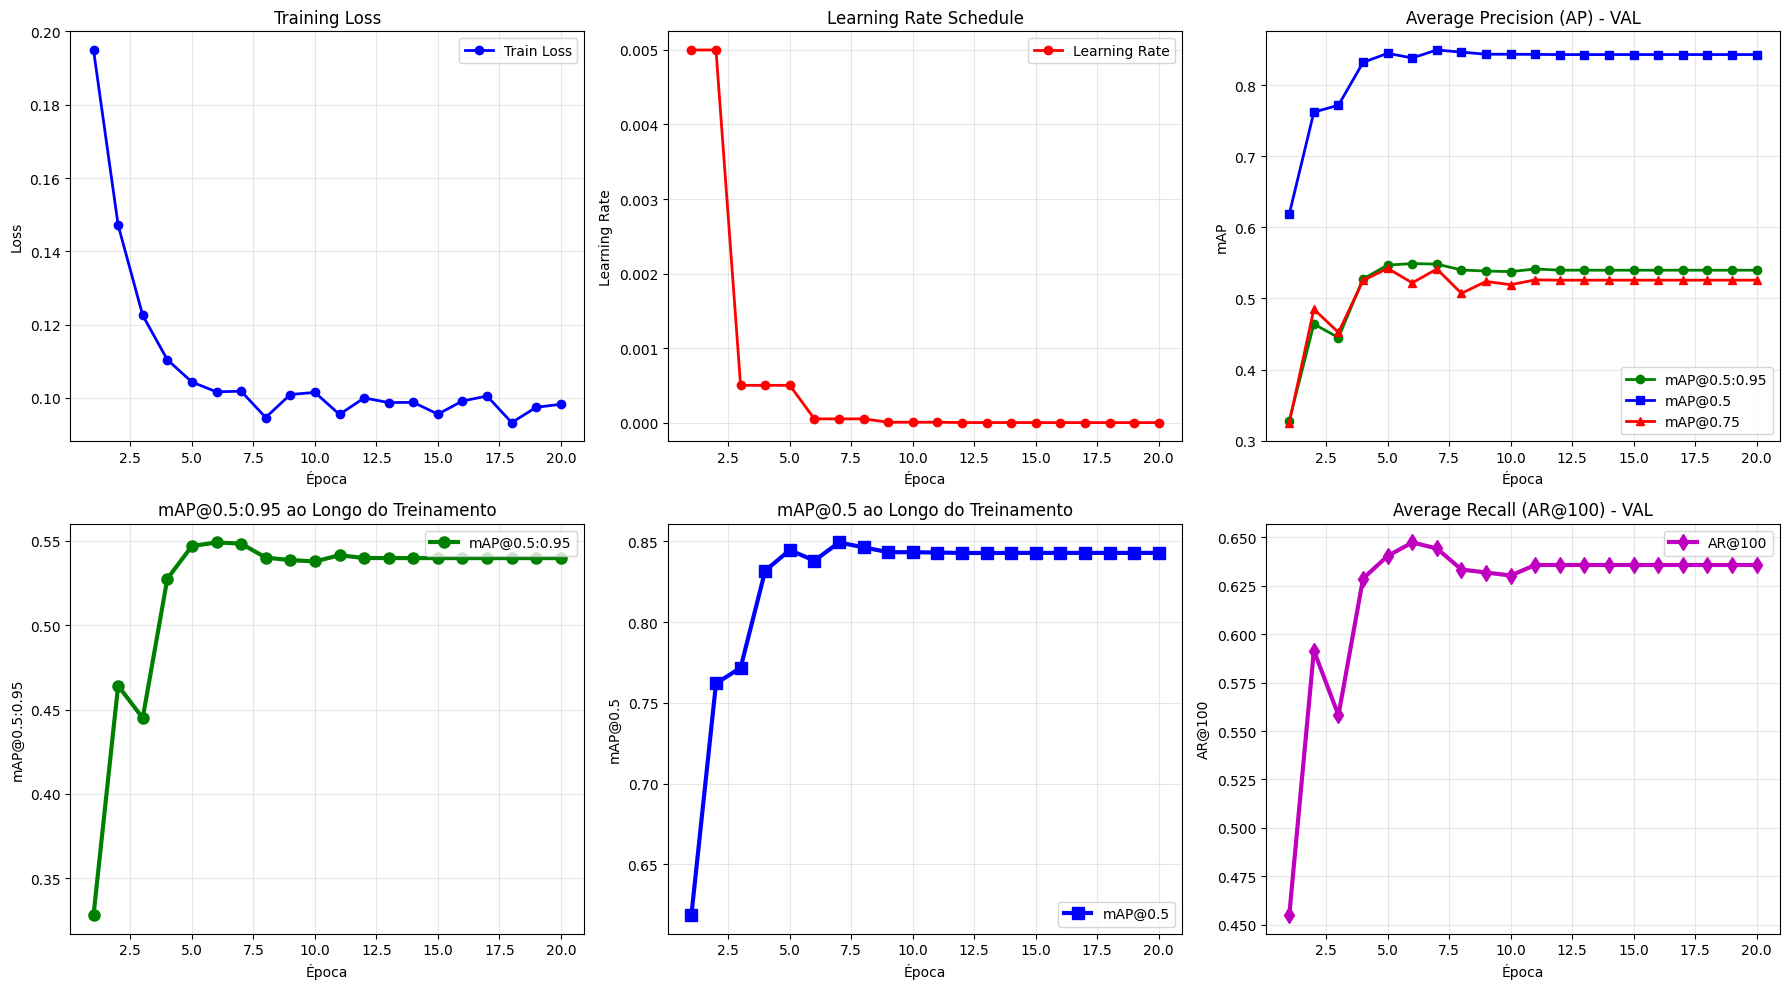

✅ Gráficos salvos em: runs/aula9_coco_gun\training_history.png


In [15]:
# ================================================================
# VISUALIZAR HISTÓRICO DE TREINAMENTO
# ================================================================

if os.path.exists(os.path.join(save_dir, "history.json")):
    with open(os.path.join(save_dir, "history.json"), 'r') as f:
        history = json.load(f)
    
        # Criar figura com múltiplos subplots
    fig = plt.figure(figsize=(18, 10))
    
    # Plot 1: Loss
    plt.subplot(2, 3, 1)
    plt.plot(history["epoch"], history["train_loss"], 'b-', linewidth=2, label='Train Loss', marker='o')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Learning Rate
    plt.subplot(2, 3, 2)
    plt.plot(history["epoch"], history["lr"], 'r-', linewidth=2, label='Learning Rate', marker='o')
    plt.xlabel('Época')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 3: mAP principais
    plt.subplot(2, 3, 3)
    plt.plot(history["epoch"], history["map50_95"], 'g-', linewidth=2, label='mAP@0.5:0.95', marker='o')
    plt.plot(history["epoch"], history["map50"], 'b-', linewidth=2, label='mAP@0.5', marker='s')
    plt.plot(history["epoch"], history["map75"], 'r-', linewidth=2, label='mAP@0.75', marker='^')
    plt.xlabel('Época')
    plt.ylabel('mAP')
    plt.title('Average Precision (AP) - VAL')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 4: mAP@0.5:0.95 (principal)
    plt.subplot(2, 3, 4)
    plt.plot(history["epoch"], history["map50_95"], 'g-', linewidth=3, label='mAP@0.5:0.95', marker='o', markersize=8)
    plt.xlabel('Época')
    plt.ylabel('mAP@0.5:0.95')
    plt.title('mAP@0.5:0.95 ao Longo do Treinamento')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 5: mAP@0.5
    plt.subplot(2, 3, 5)
    plt.plot(history["epoch"], history["map50"], 'b-', linewidth=3, label='mAP@0.5', marker='s', markersize=8)
    plt.xlabel('Época')
    plt.ylabel('mAP@0.5')
    plt.title('mAP@0.5 ao Longo do Treinamento')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 6: AR@100
    plt.subplot(2, 3, 6)
    plt.plot(history["epoch"], history["ar_all_100"], 'm-', linewidth=3, label='AR@100', marker='d', markersize=8)
    plt.xlabel('Época')
    plt.ylabel('AR@100')
    plt.title('Average Recall (AR@100) - VAL')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_history.png"), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Gráficos salvos em: {os.path.join(save_dir, 'training_history.png')}")
else:
    print("⚠️  Histórico não encontrado. Execute o treinamento primeiro.")


In [16]:
# ================================================================
# CÓDIGO MODIFICADO PARA O LOOP DE TREINAMENTO
# ================================================================
# SUBSTITUA O HISTÓRICO E O LOOP DE TREINAMENTO NA CÉLULA 9 POR ESTE CÓDIGO

# Histórico de treinamento (MODIFICADO - adicionar todas as métricas)
history = {
    "epoch": [],
    "train_loss": [],
    "lr": [],
    "map50_95": [],
    "map50": [],
    "map75": [],
    "map50_95_small": [],
    "map50_95_medium": [],
    "map50_95_large": [],
    "ar_all_1": [],
    "ar_all_10": [],
    "ar_all_100": [],
    "ar_small": [],
    "ar_medium": [],
    "ar_large": []
}

# Melhor mAP (usaremos mAP@0.5:0.95 como critério)
best_map = 0.0

print("✅ Histórico modificado para incluir todas as métricas COCO")
print("   📝 Copie este código para substituir o histórico na célula 9")


✅ Histórico modificado para incluir todas as métricas COCO
   📝 Copie este código para substituir o histórico na célula 9


In [19]:
print(f"\n{'='*60}")
print(f"📊 AVALIANDO MODELO NO DATASET DE TESTE {epoch+1}")
print(f"{'='*60}")

# Avaliar no dataset de teste
ann_path = os.path.join(root_dir, "coco_annotations_test.json")
metrics = evaluate_coco_completo( 
    model,
    test_dataset,
    ann_path,
    device=device,
    score_threshold=0.5,
    valid_indices=valid_indices
)

print(f"\n📊 MÉTRICAS DA ÉPOCA {epoch+1}:")
print(f"   ✅ mAP@0.5:      {metrics['map50']:.4f} ({metrics['map50']*100:.2f}%)")
print(f"   ✅ mAP@0.5:0.95: {metrics['map50_95']:.4f} ({metrics['map50_95']*100:.2f}%)")
print(f"   ✅ mAP@0.75:     {metrics['map75']:.4f} ({metrics['map75']*100:.2f}%)")
print(f"{'='*60}\n")

# Salvar histórico (ADICIONAR TODAS AS MÉTRICAS)
history["epoch"].append(epoch + 1)
history["train_loss"].append(avg_loss)
history["lr"].append(current_lr)
history["map50_95"].append(metrics['map50_95'])
history["map50"].append(metrics['map50'])
history["map75"].append(metrics['map75'])
history["map50_95_small"].append(metrics['map50_95_small'])
history["map50_95_medium"].append(metrics['map50_95_medium'])
history["map50_95_large"].append(metrics['map50_95_large'])
history["ar_all_1"].append(metrics['ar_all_1'])
history["ar_all_10"].append(metrics['ar_all_10'])
history["ar_all_100"].append(metrics['ar_all_100'])
history["ar_small"].append(metrics['ar_small'])
history["ar_medium"].append(metrics['ar_medium'])
history["ar_large"].append(metrics['ar_large'])

# Salvar melhor modelo (baseado em mAP@0.5:0.95)
current_map = metrics['map50_95']
if current_map > best_map:
    best_map = current_map
    model_path = os.path.join(save_dir, "best_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"\n   💾 Melhor modelo salvo! (mAP@0.5:0.95: {best_map:.4f})")
    print(f"      📂 Caminho: {model_path}")

print("✅ Código de avaliação durante treinamento criado!")
print("   📝 Adicione este código no loop de treinamento (célula 9) após atualizar o learning rate")



📊 AVALIANDO MODELO NO DATASET DE TESTE 20

🔍 INÍCIO DA AVALIAÇÃO COCO
   📂 Arquivo de anotações: dataset_final_coco\coco_annotations_test.json
   🎯 Score threshold: 0.5
   💻 Device: cuda

📋 Carregando anotações COCO...
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
   ⚠️  Adicionando chave 'info' ao dataset
   📊 Categorias encontradas: [1]
   📋 Category ID esperado: 1 (gun)

🔄 Processando 100 imagens...
   ⏳ Processadas 10/100 imagens...
   ⏳ Processadas 20/100 imagens...
   ⏳ Processadas 30/100 imagens...
   ⏳ Processadas 40/100 imagens...
   ⏳ Processadas 50/100 imagens...
   ⏳ Processadas 60/100 imagens...
   ⏳ Processadas 70/100 imagens...
   ⏳ Processadas 80/100 imagens...
   ⏳ Processadas 90/100 imagens...
   ⏳ Processadas 100/100 imagens...

✅ Processamento concluído!
   📊 Total de predições: 232
   📸 Imagens processadas: 100

📋 Filtrando anotações COCO para o subset...
   📸 Image IDs no subset: 100

📊 Calculando métricas COCO...
Loading and 


🎨 VISUALIZANDO PREDIÇÕES DO MODELO
   📸 Número de imagens: 6
   🎯 Score threshold: 0.3
   💻 Device: cuda



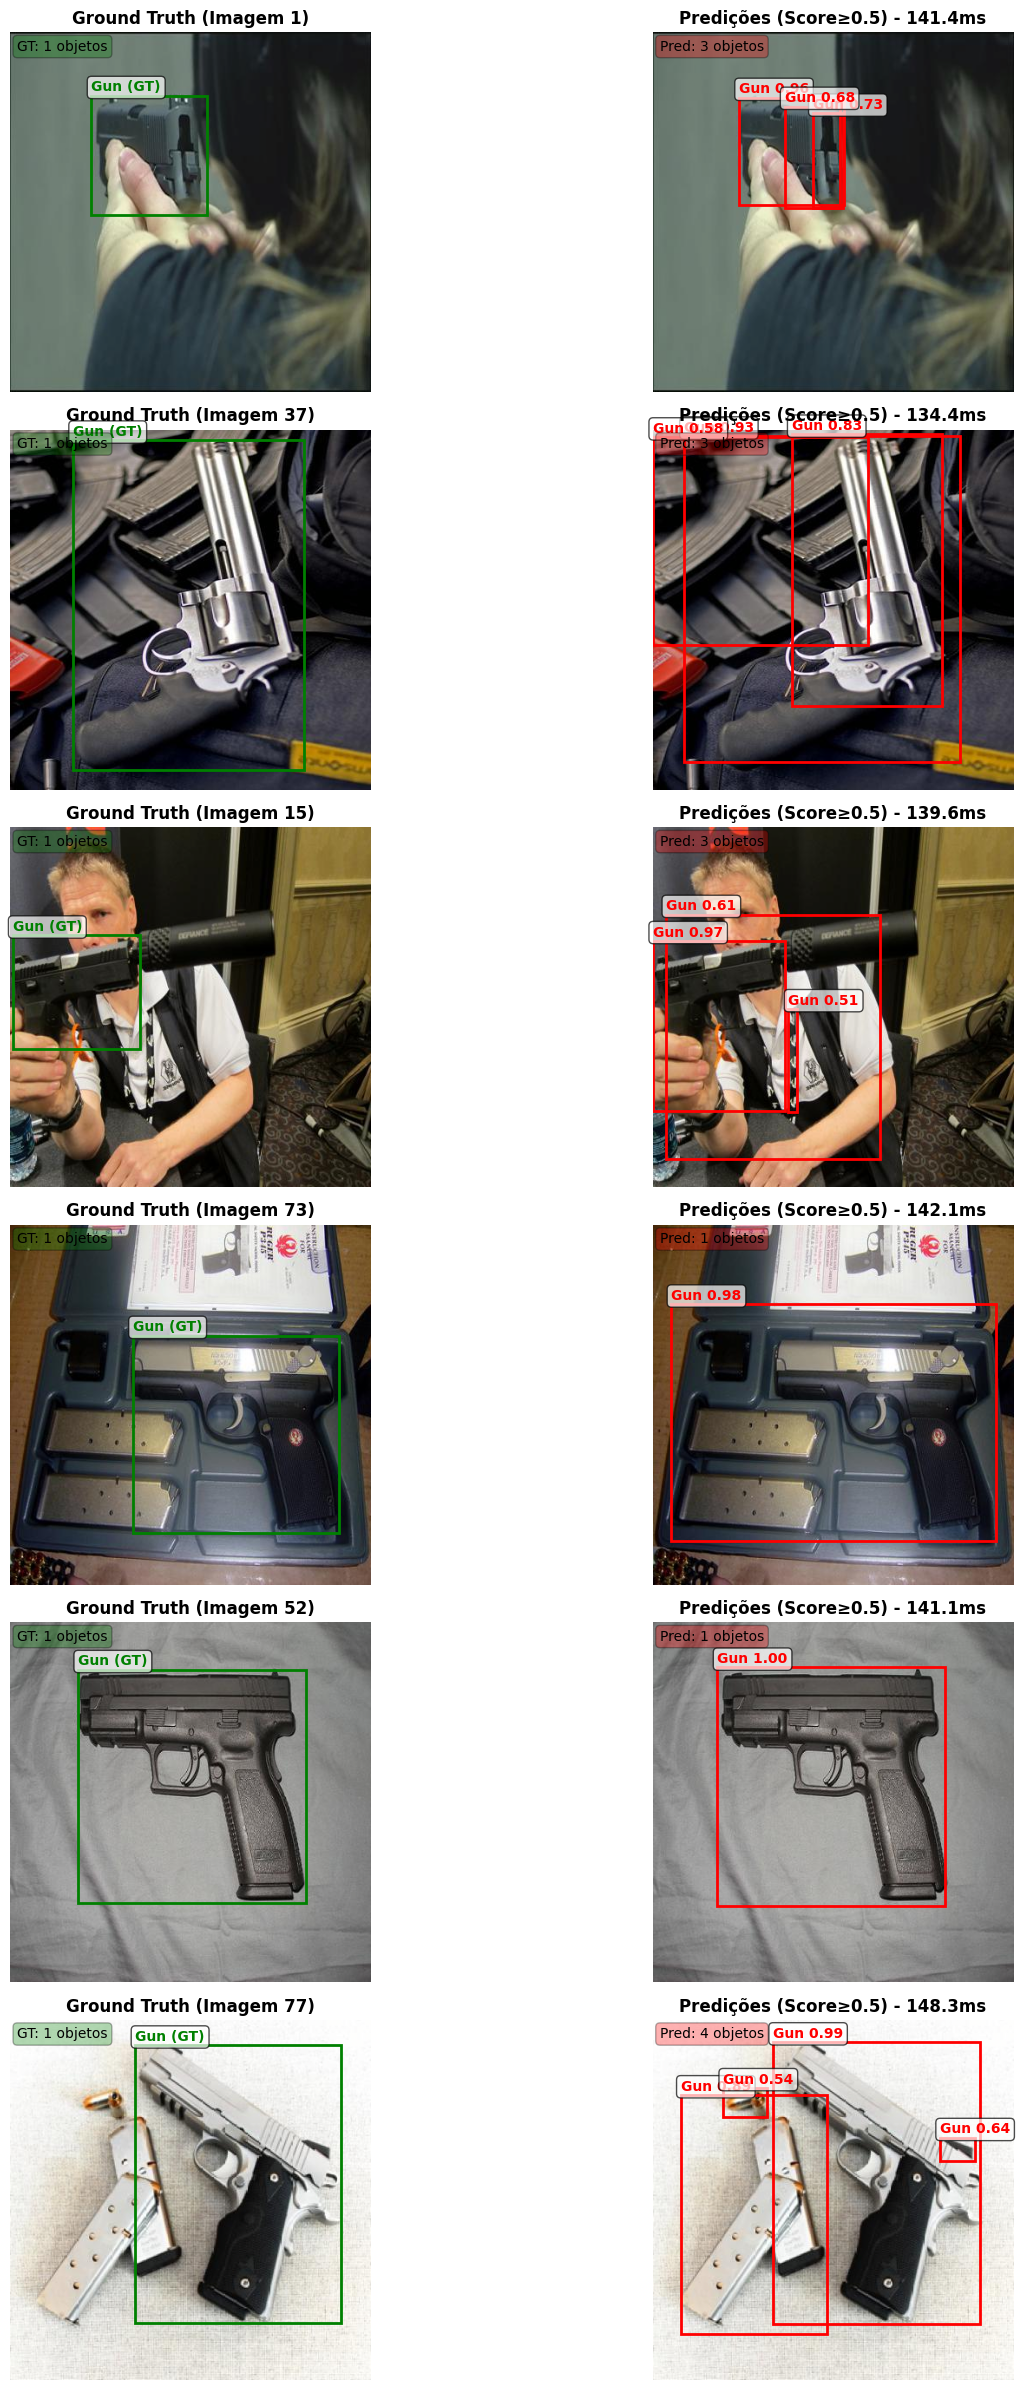


⏱️  ESTATÍSTICAS DE TEMPO DE INFERÊNCIA
   📊 Número de imagens testadas: 6
   ⏱️  Tempo médio: 141.15 ms
   📈 Desvio padrão: 4.06 ms
   ⬇️  Tempo mínimo: 134.45 ms
   ⬆️  Tempo máximo: 148.25 ms
   🚀 FPS médio: 7.08 frames/segundo



In [20]:
# ================================================================
# VISUALIZAÇÃO DE PREDIÇÕES E CÁLCULO DE TEMPO DE INFERÊNCIA
# ================================================================

import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Desnormaliza imagem tensor para visualização"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def visualize_predictions(model, dataset, device, num_images=6, score_threshold=0.3):
    """
    Visualiza predições do modelo comparando com ground truth
    
    Args:
        model: Modelo treinado
        dataset: Dataset de teste
        device: Device (cuda/cpu)
        num_images: Número de imagens para visualizar
        score_threshold: Threshold mínimo de confiança
    """
    model.eval()
    
    # Selecionar índices aleatórios
    valid_indices = [i for i in range(len(dataset)) if dataset[i] is not None]
    selected_indices = np.random.choice(valid_indices, min(num_images, len(valid_indices)), replace=False)
    
    # Lista para armazenar tempos de inferência
    inference_times = []
    
    fig, axes = plt.subplots(num_images, 2, figsize=(16, 4*num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample_idx in enumerate(selected_indices):
        # Carregar imagem e ground truth
        image_tensor, target = dataset[sample_idx]
        
        # Desnormalizar imagem para visualização
        image_np = denormalize_image(image_tensor).permute(1, 2, 0).cpu().numpy()
        image_np = np.clip(image_np, 0, 1)
        
        # Ground truth boxes
        gt_boxes = target['boxes'].cpu().numpy()
        gt_labels = target['labels'].cpu().numpy()
        
        # Fazer predição e medir tempo
        image_batch = image_tensor.unsqueeze(0).to(device)
        
        start_time = time.time()
        with torch.no_grad():
            predictions = model(image_batch)[0]
        inference_time = time.time() - start_time
        inference_times.append(inference_time)
        
        # Filtrar predições por score threshold
        pred_scores = predictions['scores'].cpu().numpy()
        pred_boxes = predictions['boxes'].cpu().numpy()
        pred_labels = predictions['labels'].cpu().numpy()
        
        mask = pred_scores >= score_threshold
        pred_boxes = pred_boxes[mask]
        pred_scores = pred_scores[mask]
        pred_labels = pred_labels[mask]
        
        # Plot Ground Truth (esquerda)
        ax_gt = axes[idx, 0]
        ax_gt.imshow(image_np)
        ax_gt.set_title(f'Ground Truth (Imagem {sample_idx})', fontsize=12, fontweight='bold')
        ax_gt.axis('off')
        
        # Desenhar caixas do ground truth (verde)
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='green', facecolor='none'
            )
            ax_gt.add_patch(rect)
            ax_gt.text(x1, y1-5, 'Gun (GT)', color='green', fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        # Plot Predições (direita)
        ax_pred = axes[idx, 1]
        ax_pred.imshow(image_np)
        ax_pred.set_title(f'Predições (Score≥{score_threshold}) - {inference_time*1000:.1f}ms', 
                         fontsize=12, fontweight='bold')
        ax_pred.axis('off')
        
        # Desenhar caixas das predições (vermelho)
        for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax_pred.add_patch(rect)
            ax_pred.text(x1, y1-5, f'Gun {score:.2f}', color='red', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        # Adicionar contadores
        ax_gt.text(0.02, 0.98, f'GT: {len(gt_boxes)} objetos', 
                  transform=ax_gt.transAxes, fontsize=10, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
        ax_pred.text(0.02, 0.98, f'Pred: {len(pred_boxes)} objetos', 
                    transform=ax_pred.transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    # Calcular estatísticas de tempo
    avg_time = np.mean(inference_times)
    std_time = np.std(inference_times)
    min_time = np.min(inference_times)
    max_time = np.max(inference_times)
    
    print(f"\n{'='*60}")
    print(f"⏱️  ESTATÍSTICAS DE TEMPO DE INFERÊNCIA")
    print(f"{'='*60}")
    print(f"   📊 Número de imagens testadas: {len(inference_times)}")
    print(f"   ⏱️  Tempo médio: {avg_time*1000:.2f} ms")
    print(f"   📈 Desvio padrão: {std_time*1000:.2f} ms")
    print(f"   ⬇️  Tempo mínimo: {min_time*1000:.2f} ms")
    print(f"   ⬆️  Tempo máximo: {max_time*1000:.2f} ms")
    print(f"   🚀 FPS médio: {1/avg_time:.2f} frames/segundo")
    print(f"{'='*60}\n")
    
    return inference_times

# Carregar melhor modelo se ainda não estiver carregado
if 'model' not in locals() or model is None:
    print("📂 Carregando melhor modelo...")
    # Verificar se save_dir está definida
    if 'save_dir' in locals():
        model_path = os.path.join(save_dir, "best_model.pth")
    else:
        # Tentar caminho padrão
        model_path = "runs/aula9_coco_gun/best_model.pth"
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
        print(f"✅ Modelo carregado de: {model_path}")
    else:
        print(f"⚠️  Modelo não encontrado em: {model_path}")
        print("   Usando modelo atual (se disponível)")

# Garantir que o modelo está no device correto
model = model.to(device)
model.eval()

print(f"\n{'='*60}")
print(f"🎨 VISUALIZANDO PREDIÇÕES DO MODELO")
print(f"{'='*60}")
print(f"   📸 Número de imagens: 6")
print(f"   🎯 Score threshold: 0.3")
print(f"   💻 Device: {device}")
print(f"{'='*60}\n")

# Visualizar predições
inference_times = visualize_predictions(
    model=model,
    dataset=test_dataset,
    device=device,
    num_images=6,
    score_threshold=0.5
)
